In [ ]:
import os
import h5py
import librosa
import itertools
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
  except RuntimeError as e:
    print(e)

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D, LSTM, Lambda
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# For reproducibility purposes
np.random.seed(42)

In [ ]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
def splitsongs(X, y, window = 0.05, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        if s.shape[0] != chunk:
            continue

        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [ ]:
"""
@description: Method to convert a list of songs to a np array of melspectrograms
"""
def to_melspectrogram(songs, n_fft=1024, hop_length=256):
    # Transformation function
    melspec = lambda y: librosa.feature.melspectrogram(y=y, n_fft=n_fft,
        hop_length=hop_length, n_mels=128)[:,:,np.newaxis]

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    # np.array([librosa.power_to_db(s, ref=np.max) for s in list(tsongs)])
    return np.array(list(tsongs))


In [ ]:
def split_convert(X, y):
    arr_specs, arr_genres = [], []
    #song_samples = 660000
    
    # Convert to spectrograms and split into small windows
    for fn, genre in zip(X, y):
        signal, sr = librosa.load(fn)
        signal = signal[:song_samples]

        # Convert to dataset of spectograms/melspectograms
        signals, y = splitsongs(signal, genre)

        # Convert to "spec" representation
        specs = to_melspectrogram(signals)

        # Save files
        arr_genres.extend(y)
        arr_specs.extend(specs)
    
    return np.array(arr_specs), to_categorical(arr_genres)

In [ ]:
def read_data(src_dir, genres, song_samples):    
    # Empty array of dicts with the processed features from all files
    arr_fn = []
    arr_genres = []

    # Get file list from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        temp_file_list = os.listdir(folder)
        for file in temp_file_list:
          file_name = folder + "/" + file
          arr_fn.append(file_name)
          arr_genres.append(genres[x])
          
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        arr_fn, arr_genres, test_size=0.3, random_state=42, stratify=arr_genres
    )
    
    # Split into small segments and convert to spectrogram
    X_train, y_train = split_convert(X_train, y_train)
    X_test, y_test = split_convert(X_test, y_test)

    return X_train, X_test, y_train, y_test

In [ ]:
song_samples = 660000
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

# gtzan_dir = '/content/drive/MyDrive/Music_Genre_Classification/data/genres/'          

# Prjwal's computer 
gtzan_dir = '/content/drive/MyDrive/Colab Notebooks/ECE 539/Project/ECE_539_Project/Music_Genre_Classification/data/genres/'

# Read the data
X_train, X_test, y_train, y_test = read_data(gtzan_dir, genres, song_samples)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(np.reshape(X_train,((X_train.shape[0],X_train.shape[1],X_train.shape[2]))).shape)
# X2_train = np.array(np.reshape(X_train,((X_train.shape[0],X_train.shape[1],X_train.shape[2]))))
# X2_test = np.array(np.reshape(X_test,((X_test.shape[0],X_test.shape[1],X_test.shape[2]))))
X2_train = np.squeeze(X_train,axis=3)
X2_test = np.squeeze(X_test,axis=3)
print(X2_train.shape)

(27261, 128, 129, 1) (11700, 128, 129, 1) (27261, 10) (11700, 10)
(27261, 128, 129)
(27261, 128, 129)


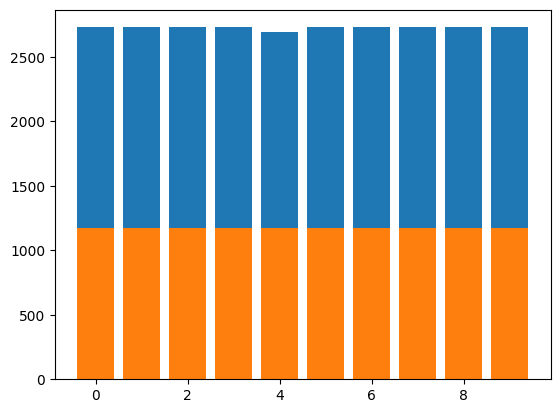

In [ ]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

In [ ]:
from tensorflow.keras.utils import Sequence

class GTZANGenerator(Sequence):
    def __init__(self, X, y, batch_size=64, is_test = False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.is_test = is_test
    
    def __len__(self):
        return int(np.ceil(len(self.X)/self.batch_size))
    
    def __getitem__(self, index):
        # Get batch indexes
        signals = self.X[index*self.batch_size:(index+1)*self.batch_size]

        # Apply data augmentation
        if not self.is_test:
            signals = self.__augment(signals)
        return signals, self.y[index*self.batch_size:(index+1)*self.batch_size]
    
    def __augment(self, signals, hor_flip = 0.5, random_cutout = 0.5):
        spectrograms =  []
        for s in signals:
            signal = copy(s)
            
            # Perform horizontal flip
            if np.random.rand() < hor_flip:
                signal = np.flip(signal, 1)

            # Perform random cutoout of some frequency/time
            if np.random.rand() < random_cutout:
                lines = np.random.randint(signal.shape[0], size=3)
                cols = np.random.randint(signal.shape[0], size=4)
                signal[lines, :, :] = -80 # dB
                signal[:, cols, :] = -80 # dB

            spectrograms.append(signal)
        return np.array(spectrograms)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        np.random.shuffle(self.indexes)
        return None

In [ ]:
#base_model = ResNet50(input_shape=(128, 129, 1))
#model = ResNet50(X_train[0].shape, len(genres))
#

In [ ]:
# def conv_block(x, n_filters, pool_size=(2, 2)):
#     x = Conv2D(n_filters, (3, 3), strides=(1, 1), padding='same')(x)
#     x = Activation('relu')(x)
#     x = MaxPooling2D(pool_size=pool_size, strides=pool_size)(x)
#     x = Dropout(0.25)(x)
#     return x

In [ ]:
def create_model(input_shape, num_genres):
    inpt = Input(shape=input_shape)
    x = Lambda(lambda x: x[:,:,:,0], input_shape=(*input_shape, 1))(inpt)
    x = LSTM(units=128, dropout=0.05, recurrent_dropout=0.35, return_sequences=True, input_shape=input_shape)(x)
    x = LSTM(units=32, dropout=0.05, recurrent_dropout=0.35, return_sequences=True)(x)
    # x = LSTM(units=64, dropout=0.05, recurrent_dropout=0.35, return_sequences=True)(x)
    # x = LSTM(units=32, dropout=0.05, recurrent_dropout=0.35, return_sequences=False)(x)
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', 
              kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    x = Dropout(0.25)(x)
    predictions = Dense(num_genres, 
                        activation='softmax', 
                        kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    
    model = Model(inputs=inpt, outputs=predictions)
    return model

In [ ]:
#print(input_shape)
model = create_model(X_train[0].shape, len(genres))

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 129, 1)]     0         
                                                                 
 lambda (Lambda)             (None, 128, 129)          0         
                                                                 
 lstm (LSTM)                 (None, 128, 256)          395264    
                                                                 
 lstm_1 (LSTM)               (None, 128, 128)          197120    
                                                                 
 lstm_2 (LSTM)               (None, 128, 64)           49408     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 flatten (Flatten)           (None, 32)                0     

Loss function

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.95,
    patience=30,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-6
)

In [ ]:
# Generators
batch_size = 128
train_generator = GTZANGenerator(X_train, y_train)
steps_per_epoch = np.ceil(len(X_train)/batch_size)

validation_generator = GTZANGenerator(X_test, y_test)
val_steps = np.ceil(len(X_test)/batch_size)

In [ ]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=300,
    verbose=1,
    callbacks=[reduceLROnPlat])

Epoch 1/150


<ipython-input-21-c619abd23725>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


213/213 [==============================] - 339s 2s/step - loss: 2.6273 - accuracy: 0.1288 - val_loss: 2.3321 - val_accuracy: 0.1061 - lr: 0.0010
Epoch 2/150
213/213 [==============================] - 322s 2s/step - loss: 2.3129 - accuracy: 0.1102 - val_loss: 2.3059 - val_accuracy: 0.1126 - lr: 0.0010
Epoch 3/150
213/213 [==============================] - 323s 2s/step - loss: 2.3043 - accuracy: 0.1252 - val_loss: 2.3029 - val_accuracy: 0.1126 - lr: 0.0010
Epoch 4/150
213/213 [==============================] - 324s 2s/step - loss: 2.3035 - accuracy: 0.0943 - val_loss: 2.3028 - val_accuracy: 0.1126 - lr: 0.0010
Epoch 5/150
213/213 [==============================] - 323s 2s/step - loss: 2.3036 - accuracy: 0.0680 - val_loss: 2.3024 - val_accuracy: 0.1126 - lr: 0.0010
Epoch 6/150
213/213 [==============================] - 324s 2s/step - loss: 2.3024 - accuracy: 0.1027 - val_loss: 2.3021 - val_accuracy: 0.1126 - lr: 0.0010
Epoch 7/150
213/213 [==============================] - 324s 2s/step - 

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

In [ ]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, keys, normalize=True)

Majority Vote

In [ ]:
def majority_vote(scores):
    values, counts = np.unique(scores,return_counts=True)
    ind = np.argmax(counts)
    return values[ind]

In [ ]:
preds = model.predict(X_test, batch_size=128, verbose=0)

In [ ]:
# Each sound was divided into 39 segments in our custom function
scores_songs = np.split(np.argmax(preds, axis=1), 300)
scores_songs = [majority_vote(scores) for scores in scores_songs]

In [ ]:
# Same analysis for split
label = np.split(np.argmax(y_test, axis=1), 300)
label = [majority_vote(l) for l in label]

In [ ]:
# from sklearn.metrics import accuracy_score

# print("majority voting system (acc) = {:.3f}".format(accuracy_score(label, scores_songs)))
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
print("majority voting system (acc) = {:.3f}".format(accuracy_score(label, scores_songs)))
print("precision recall f1 score",precision_recall_fscore_support(label, scores_songs, average='macro'))

In [ ]:
# Save the model
model.save('../models/resnet.h5')